In [1]:
import sys
sys.path.append('/workspaces/bha2/src')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from connectivity_functions import *
from tree_functions import *
from ni_functions import *
from io_functions import load_data
import os
import json
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6, 6)

/opt/conda/lib/python3.9/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [6]:
project_path = "/workspaces/bha2"
conn_sizes = [183, 391, 568, 729, 964, 1242, 1584, 1795, 2165]
gammas_vec = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

lvlmin = 10
lvlmax = 60
max_crossmod = np.empty((2, len(conn_sizes)))

for conn_size in conn_sizes:
    if os.path.exists(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy")):
        fcm = np.load(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy"))
        scm = np.load(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy"))
        print("fcm and scm loaded from tmp folder")
    else:
        sc_group = load_data(os.path.join(project_path, "data", "raw", "n" + str(conn_size), "sc"))
        fc_group = load_data(os.path.join(project_path, "data", "raw", "n" + str(conn_size), "fc"))
        fcm, scm = connectome_average(fc_group, sc_group)
        np.save(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy"), fcm)
        np.save(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy"), scm)
    
    zero_rows_sc = np.where(~scm.any(axis=1))[0]
    fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(zero_rows_sc, fcm, scm)
    density = np.where(scm_nonzero.flatten() > 0, 1, 0).sum(dtype=float) / (len(scm_nonzero.flatten()))
    fcm_thr = density_threshold(fcm_nonzero, density)
    zero_rows_fc = np.where(~fcm_thr.any(axis=1))[0]
    fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(zero_rows_fc, fcm_thr, scm_nonzero)
    fcm_bin = np.where(abs(fcm_nonzero) > 0, 1, 0)
    scm_bin = np.where(scm_nonzero > 0, 1, 0) 

    crossmod_gammas = np.empty((lvlmax - lvlmin, 1))

    for g in gammas_vec:
        tree = json.loads(open(os.path.join(project_path, "data", "results", "n" + str(conn_size),
            "tree_equaldensity_bin_full_g_" + str(g) + ".json")).read())
        crossmod = []
        mod_sc = []
        mod_fc = []
        sim_lvl = []
        for l in range(lvlmin,lvlmax):
            level, labels = level_from_tree(tree, l)
            T = T_from_level(level)
            sim = similarity_mean_level(fcm_nonzero, scm_nonzero, level)
            mod_sc_lvl = modularity(scm_nonzero, T)
            mod_fc_lvl = modularity(fcm_nonzero, T)
            c = pow((sim * mod_sc_lvl * mod_fc_lvl), (1 / 3))
            crossmod.append(c)
        crossmod_gammas = np.hstack((crossmod_gammas, np.array(crossmod).reshape(-1,1)))
    xmod = crossmod_gammas[:,1:]
    max_crossmod[0, conn_sizes.index(conn_size)] = np.max(xmod)
    x,y = np.where(xmod == np.nanmax(xmod))
    max_crossmod[1, conn_sizes.index(conn_size)] = gammas_vec[y[0]]

fcm and scm loaded from tmp folder
fcm and scm loaded from tmp folder
fcm and scm loaded from tmp folder
fcm and scm loaded from tmp folder
fcm and scm loaded from tmp folder
fcm and scm loaded from tmp folder
fcm and scm loaded from tmp folder
fcm and scm loaded from tmp folder
fcm and scm loaded from tmp folder


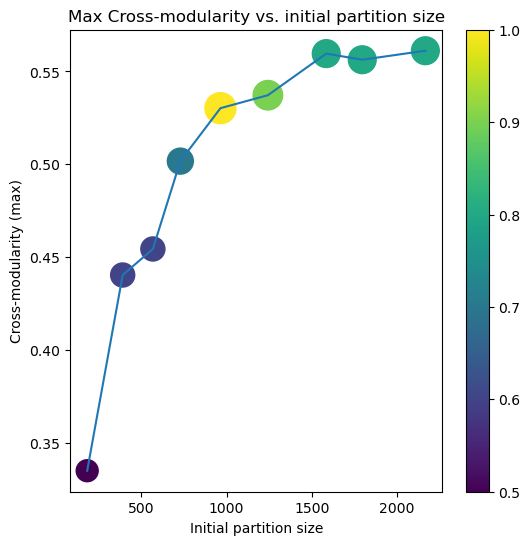

In [7]:
plt.plot(conn_sizes, max_crossmod[0,:])
plt.xlabel("Initial partition size")
plt.ylabel("Cross-modularity (max)")
plt.title("Max Cross-modularity vs. initial partition size")
plt.scatter(conn_sizes, max_crossmod[0,:],s=max_crossmod[1,:]*500, c=max_crossmod[1,:], cmap='viridis')
plt.colorbar()
plt.show()